
# Project Proposal — Heart Disease Prediction

## 1.1 - Introduction

Heart disease and its effective diagnosis is a global health challenge. In this proposal, we aim to address diagnosing heart diseases using machine learning techniques. We will attempt to detect the presence of heart disease in patients by leveraging a heart disease dataset obtained from Kaggle. 
### Data Selection and Justification

While the original dataset from Kaggle comprises 16 variables, we have strategically chosen 6 variables based on their clinically established correlation with heart disease. By focusing on a subset of six variables, we aim to create a model that is both efficient and effective, avoiding the complexity and potential overfitting associated with using a larger number of variables.

1. **Patient ID (id)**: This identifier is used to track individual patient data.
2. **Age (age)**: Age is a well-known risk factor for heart disease. Older individuals have a higher risk, making this variable crucial for our model.
3. **Resting Blood Pressure (trestbps)**: High blood pressure is a known risk factor for heart disease. It can lead to hardening and thickening of the arteries, increasing heart disease risk.
4. **Serum Cholesterol (chol)**: High cholesterol levels can lead to atherosclerosis, increasing heart disease risk.
5. **Maximum Heart Rate (thalch)**: Lower maximum heart rate during exercise is associated with a higher risk of heart disease.
6. **Heart Disease (presence)**: This variable, indicating the degree of blockages in major vessels, is a direct measure of heart disease. In the initial dataset, the diagnosis (num) ranges from 0 (no presence) to 4. However, we have compressed it into two categories:

     - P (present): < 50% diameter narrowing, indicating significant heart disease.
     - A (absent): > 50% diameter narrowing, indicating no significant heart disease.
     
The decision to compress the "num" column (or presence in our study) into two classes (P and A) stems from the need for a clear, binary classification for our KNN classification model. This simplification also addresses potential issues with ambiguous labels in the dataset —allowing us to effectively train our model to distinguish only between two crucial states of heart diseases (present or absent). 

### Project Goal:

**Can a K-nearest neighbors (KNN) classification effectively diagnose heart disease using age, resting blood pressure, cholesterol levels, and maximum heart rate as predictors?**

This approach aims to provide a simplified yet accurate tool for early heart disease diagnosis, potentially aiding in prompt treatment and management.

## 1.2 - Hypothesis and expectations


**Hypothesis:**

We expect that our K-nearest neighbors (KNN) classification model, using age, resting blood pressure, serum cholesterol levels, and maximum heart rate as predictors, will effectively diagnose heart disease accurately distinguishing between the presence and absence of the condition.

This hypothesis is based on the selection of clinically significant variables: age, resting blood pressure, serum cholesterol, and maximum heart rate. These factors are widely acknowledged in medical literature as key indicators of heart disease risk, providing a strong foundation for their use in predictive modeling.


**How are we going to measure the effectiveness of our model ?**

Since our study is in the medical field, determining an "acceptable" percentage for accuracy, precision, and recall of our classifier is important. That's because low percentages for accuracy, precision, and recall imply a higher risk of misdiagnosing heart disease, which can have serious, potentially life-threatening consequences for patients.

<u> Accuracy </u>: This measures how often the model is correct overall. In medical diagnostics, a high level of accuracy is desirable, so we are aiming for above 90%. However, accuracy alone can be misleading, especially if the data is imbalanced (i.e., there are many more healthy people than those with heart disease in your dataset).

<u>Precision </u>: (Positive Predictive Value): Precision indicates the proportion of positive identifications that were actually correct. For heart disease prediction, high precision is crucial to avoid false positives, which can lead to unnecessary stress, additional testing, and potentially harmful interventions for patients. So we are also aiming for above 90%.

<u> Recall (Sensitivity)</u>: Recall assesses how well the model identifies actual positives. In the case of heart disease, a high recall is essential because missing a diagnosis (a false negative) can have serious, potentially life-threatening consequences. Therefore, the recall rate should also be as high as possible, so we target above 90%.

## 2 - Methods and results

 ### 2.1 Data Cleaning and Wrangling

First, We will import the dataset and perform data processing. This includes handling any missing values, addressing outliers, and standardizing our selected numerical predictors : age (`age`), maximum heart rate achieved (`thalch`), resting blood pressure (`trestbps`),and serum cholesterol (`chol`). 

In [2]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(shiny)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

**Preparing the Heart Disease Dataframe**

Let's import the original heart disease data from github- as we uploaded the csv file on our remote repository

In [3]:
url <- "https://raw.githubusercontent.com/MAmouzouvi/dsci-100-2022w1-group-10/main/data/heart_disease_uci.csv"

heart_disease_uci <- read_csv(url)
head(heart_disease_uci)

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1
4,37,Male,Cleveland,non-anginal,130,250,FALSE,normal,187,FALSE,3.5,downsloping,0,normal,0
5,41,Female,Cleveland,atypical angina,130,204,FALSE,lv hypertrophy,172,FALSE,1.4,upsloping,0,normal,0
6,56,Male,Cleveland,atypical angina,120,236,FALSE,normal,178,FALSE,0.8,upsloping,0,normal,0


`Figure 2.1.1: Data frame showing the untransformed observations of the heart disease data set.`

**Selection**

Now, we will reduce the data frame to include only our selected variables in order to get the most accurate results for our question.  

Moreover, we notice the variable `num` is the diagnosis of the heart disease, which is not a very clear label, so let's change it to `presence` which is a more descriptive label.

In [4]:
heart_disease_data <- heart_disease_uci |> 
         rename(presence = num) |>
         select(id, age, trestbps, chol, thalch, presence)
heart_disease_data

id,age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63,145,233,150,0
2,67,160,286,108,2
3,67,120,229,129,1
⋮,⋮,⋮,⋮,⋮,⋮
918,55,122,223,100,2
919,58,NA,385,NA,0
920,62,120,254,93,1


`Figure 2.1.2: Data frame showing the transformed observations of the heart disease data set including selected variables (id, age, trestbps, chol, thalch, presence).` 

**Categorical Variable and Data Wrangling**

Since we will be working with `presence` as a categorical variable, let's convert it to a factor type. 

Let's also compress the `presence` variable into two classes (`P` for present and `A` for absent) to allow for a clearer binary classification for our KNN classification model. This is to address potential issues with ambiguous labels in the dataset— allowing us to effectively train our model to distinguish only between two crucial states of heart diseases (present or absent).

Finally, we remove rows with `NA` values

In [5]:
# mutate presence to a factor
heart_disease_data <- heart_disease_data |>
            mutate(presence = ifelse(presence == 0, "P", "A")) |> 
            mutate(presence = as_factor(presence))

# Taking out the NA value in the dataset
heart_disease_data <- na.omit(heart_disease_data)
heart_disease_data

id,age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,145,233,150,P
2,67,160,286,108,A
3,67,120,229,129,A
⋮,⋮,⋮,⋮,⋮,⋮
916,54,127,333,154,A
918,55,122,223,100,A
920,62,120,254,93,A


`Figure 2.1.3: Table of heart disease data reflecting the new classes for presence (A and P) as well as the removal of missing values`

 ### 2.2 - Data Pre-processing and Summary

**Splitting our data into training and testing sets**

In [6]:
set.seed(3456)

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = presence)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

In [7]:
set.seed(3456)

num_of_observations <- nrow(heart_disease_train)

# Table that reports the percentage of observations in presence (N vs P)
percentage_per_P_and_A <- heart_disease_train |>
  group_by(presence) |>
  summarize(
    count = n(),
    percentage = n() / num_of_observations * 100
  )
percentage_per_P_and_A

presence,count,percentage
<fct>,<int>,<dbl>
P,279,44.71154
A,345,55.28846


`Figure 2.2.1: A table that summarizes the number of P (present) and A (absent) diagnoses from the observations in the training data with missing values removed.`

From the above table, we observed that the percentages for both P (45%) and A (55%) are almost similar, thus we decided to continue with our sample without extra measures to balance them equally since there is not a drastic difference. 

**Summary table of the Means of the chosen Predictors**

In [8]:
set.seed(3456)

mean_of_predictors <- heart_disease_train |>
  group_by(presence) |>
  summarize(across(age:thalch, ~ mean(.)))

mean_of_predictors

presence,age,trestbps,chol,thalch
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
P,50.31183,129.0072,227.8889,150.1147
A,55.53333,134.4290,172.3507,128.1130


`Figure 2.2.2: A summary table showing the means of each predictor variable selected for each diagnosis of heart disease`

From this table we can observe that there is a great difference in the means of `chol` and `thalch` between the presence and absence of heart disease. This could imply that they are good predictors, however, we will be doing further analysis on scaled data to test this assumption, as the unscaled data is not enough.

 ### 2.3 - Visualization

**Scaling and Centering the Dataframe**

In [9]:
set.seed(3456)
heart_disease_recipe  <- recipe(presence ~ age + trestbps + chol + thalch, data = heart_disease_train) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors()) |>
                       prep()

heart_disease_train_scaled <- bake(heart_disease_recipe, heart_disease_train)

heart_disease_train_scaled 

age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.4838148,-0.6205049,0.2808761,-0.3474694,A
0.9462507,0.4132558,0.6251594,0.8560128,A
1.0537635,-0.1036246,0.5015705,0.3513267,A
⋮,⋮,⋮,⋮,⋮
0.4086866,-0.1036246,0.0866650,-1.6285956,P
1.5913277,0.1031276,0.5015705,0.5066147,P
-0.2363904,-0.9306331,0.5368816,-1.6285956,P


`Figure 2.3.1: Table summarizing the scaled data of the heart disease data set.`

**Graphs : GGPAir plots**

In [10]:
install.packages("GGally")
library(GGally)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Let's create a ggpair plot in order to observe how each variable influence the `presence` variable

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


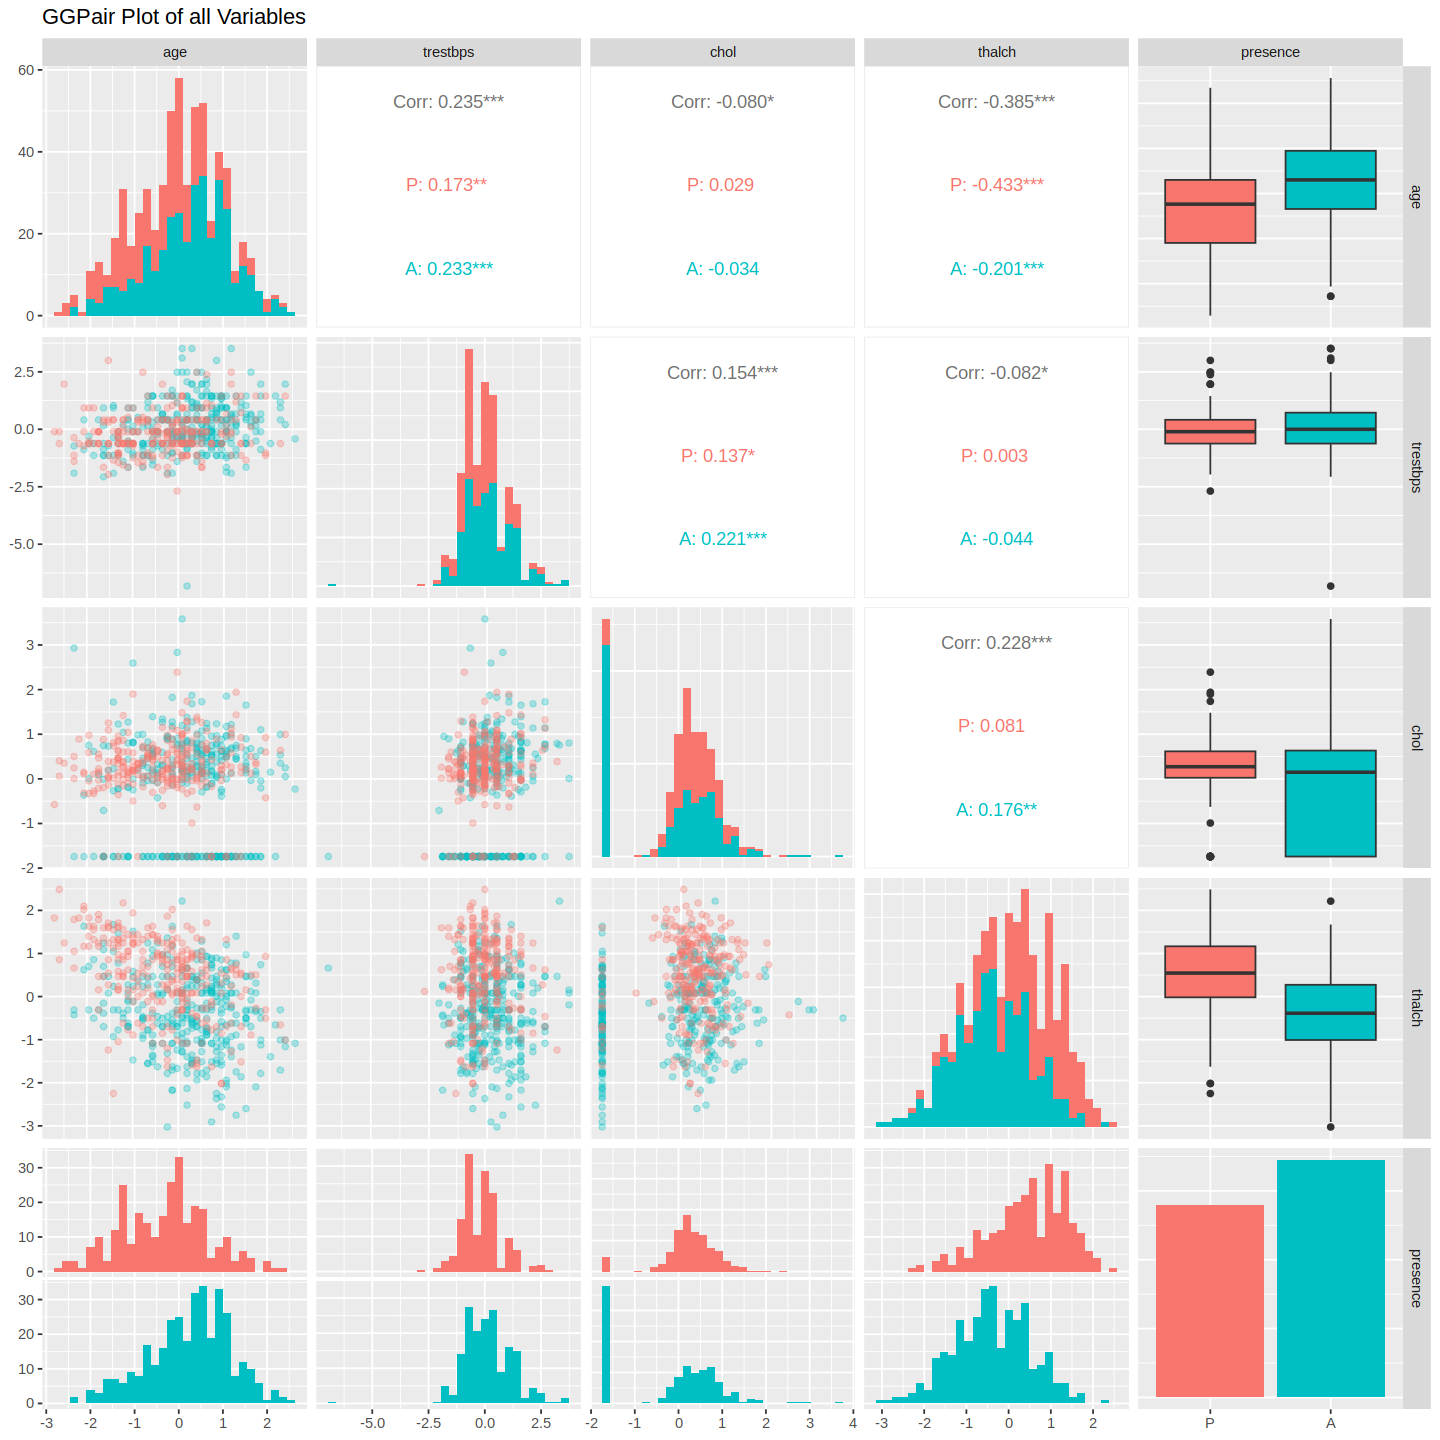

In [11]:
set.seed(3456)
# Getting the GGpair Plot to compare the trend between each variable 
options(repr.plot.width = 12, repr.plot.height = 12)
heartdisease_pairplot <- heart_disease_train_scaled |> 
    ggpairs(
        mapping = aes(color = presence),
        lower = list(continuous = wrap('points', alpha = 0.3)),
        diag = list(continuous = "barDiag")) +
    ggtitle("GGPair Plot of all Variables")


heartdisease_pairplot

`Figure 2.3.2: Multiple graphs showing the distributions of each of the chosen predictors tested against one another. The right-most column of graphs reveal box-plots to test each predictor against the presence (red) or absence (blue) of heart disease`. 

#### GGpair Graph Observation

Based on the above graphs, we focused on the right-most column to determine which predictors are most relevant for our study as they compare each variable to `presence`. We observe that the `trestbps` (Resting Blood Pressure) percentile boxes are very similar in their ranges and means. Thus, this reveals that the variable does not significantly contribute to help differentiate between each diagnosis, A (absent) and P (present), for heart disease. Therefore, we will eliminate the `trestbps` predictor to get better prediction results to our study. 

### 2.4 - Data Modelling and classifier training

**Updating dataset**

Let's remove trestbps from our training and testing dataset

In [12]:
heart_disease_train_updated <- select(heart_disease_train, -trestbps)
heart_disease_train_updated

heart_disease_test_updated <- select(heart_disease_test, -trestbps)

id,age,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,67,229,129,A
7,62,268,160,A
9,63,254,147,A
⋮,⋮,⋮,⋮,⋮
905,57,207,96,P
910,68,254,151,P
911,51,258,96,P


`Figure 2.4.1: A glimpse of the data frame after the removal of the trestbps predictor. The data now only includes the variables id, age, chol, thalc and presence.`

**Classifier Tuning**


In [13]:
install.packages("kknn")
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



The first step in training our model is choosing the parameter K, to be able to evaluate the classifier using only the training data. To do this, we will compare the classifier’s performance for different values of  K, and pick the best using only the training data. 

**Cross-validation**

Let's perform a 5-fold cross-validation on our training data

In [14]:
set.seed(3456)

## Let's split the training data in 5 folds

k_vfold <- vfold_cv(heart_disease_train_updated, v = 5, strata = presence)


## create a new receipe after removing `trestbps`
new_heart_disease_recipe  <- recipe(presence ~ age + chol + thalch , data = heart_disease_train_updated) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())


# Create the spec for heart disease following the classification method
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 

**k_vals and workflow**

Let's then create the k_vals data frame with the neighbors variable containing values from 1 to 100 (stepping by 5) using the seq function- and fit the knn model into a workflow

In [15]:
set.seed(3456)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))


In [16]:
# fit the knn model into a workflow
knn_fit <- workflow() |>
    add_recipe(new_heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics() 

**Accuracy vs K-values Table**

The table below shows the accuracies vs K-values- found doing our cross-validation on the training data, we will use this table together with the K-values graph to choose the best K value

In [17]:
set.seed(3456)
accuracies <- knn_fit |>
    filter(.metric == "accuracy")


accuracies |>
    arrange(desc(mean))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.7451355,5,0.01613009,Preprocessor1_Model05
36,accuracy,binary,0.7387484,5,0.01812124,Preprocessor1_Model08
31,accuracy,binary,0.7387355,5,0.01869688,Preprocessor1_Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,accuracy,binary,0.7147484,5,0.009947868,Preprocessor1_Model02
96,accuracy,binary,0.7147355,5,0.005513529,Preprocessor1_Model20
1,accuracy,binary,0.6489548,5,0.014077508,Preprocessor1_Model01


`Figure 2.4.2: A glimpse of the accuracies for each K-value on the training data using the 5-fold cross-validation`

**Accuracy vs K plot**

We can decide which value of K-neighbors is the best by plotting the accuracy on training data versus K as shown in figure 2.4.3.

In [1]:
## K-values graph vs accuracy

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Estimation Accuracy for each value of K") +
    theme(text = element_text(size = 12))

# This code print out the graph for showing K-nearest Neighbor Mean Distribution
cross_val_plot

ERROR: Error in ggplot(accuracies, aes(x = neighbors, y = mean)): could not find function "ggplot"


`Figure 2.4.3: Graph of K-values against their accuracy estimates to the model.`

##### K-nearest neighbors graph observation
Looking at the above graph, the maximum value of the plot (the highest point) appears to be between 15 and 25. Using then the accuracies table, it effectively reveals that K with the greatest accuracy estimate for our model is 21. Thus, we will select this value, K = 21 to train our classifier.

#### Training Classifier with K = 21

In [19]:
set.seed(3456)

heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification") 


heart_disease_fit_k21 <- workflow() |>
    add_recipe(new_heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    fit(data = heart_disease_train_updated)

heart_disease_fit_k21

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2612179
Best kernel: rectangular
Best k: 21

### 2.5 - Testing and Performance Evaluation

**Predicting the labels**

Let's predict the labels of the testing data using our classifier

In [20]:
# heart_disease_fit 
heart_disease_test_predictions <- predict(heart_disease_fit_k21, heart_disease_test_updated) |>
      bind_cols(heart_disease_test_updated)

heart_disease_test_predictions

.pred_class,id,age,chol,thalch,presence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
A,2,67,286,108,A
P,10,53,203,155,A
A,13,56,256,142,A
⋮,⋮,⋮,⋮,⋮,⋮
A,898,64,258,130,A
A,918,55,223,100,A
A,920,62,254,93,A


`Figure 2.5.1: A table showing a summary of the predictions of heart disease presence using our age, chol and thalch as predictors`

From the glimpse of the data provided, we can already see a single instance of our model incorrectly predicting heart disease. Although all other instances were correctly estimated, this indicates our model may not entirely accurate. Thus, we will evaluate performance of our model in the following steps.

**Evaluating performance**

In [21]:
heart_disease_test_predictions |>
  metrics(truth = presence, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6952381


`Figure 2.5.2: Data revealing the accuracy of our Knn model`

According to the Figure 4.3, our model did a moderate job of predicting the diagnosis of heart disease from our selected predictors with an accuracy of about 70%. However, we will need more evaluation metrics in order to come to a conclusion. Thus, We will further evaluate the performance of our model below using a confusion matrix and then calculating the prediction and recall values.

**Confusion Matrix**

We are using P (present) as the positive prediction and A (absent) as the negative prediction

In [22]:
confusion <- heart_disease_test_predictions |>
             conf_mat(truth = presence, estimate = .pred_class)
confusion

          Truth
Prediction  P  A
         P 57 27
         A 37 89

`Figure 2.5.3: Confusion matrix showing the number of correct and incorrect predictions of our estimates.`

**Calculating the Prediction and Recall values**

*accuracy = number of correct predictions / total number of predictions*

*precision = number of correct postive predicitons / total number of positive predictions*

*recall = number of correct positive predicitons / total number of positive test observations*

In [23]:
accuracy <- (57 + 89)/(57 + 89 + 37 + 27)
accuracy

precision <- (57)/(57 + 27)
precision

recall <- (57)/(57 + 37)
recall

[1] 0.6952381

[1] 0.6785714

[1] 0.606383

### 2.6 - Final visualization

For the final visualisation, let's plot accuracy. That is let's plot correct predictions (true positives and true negatives) against all predictions.

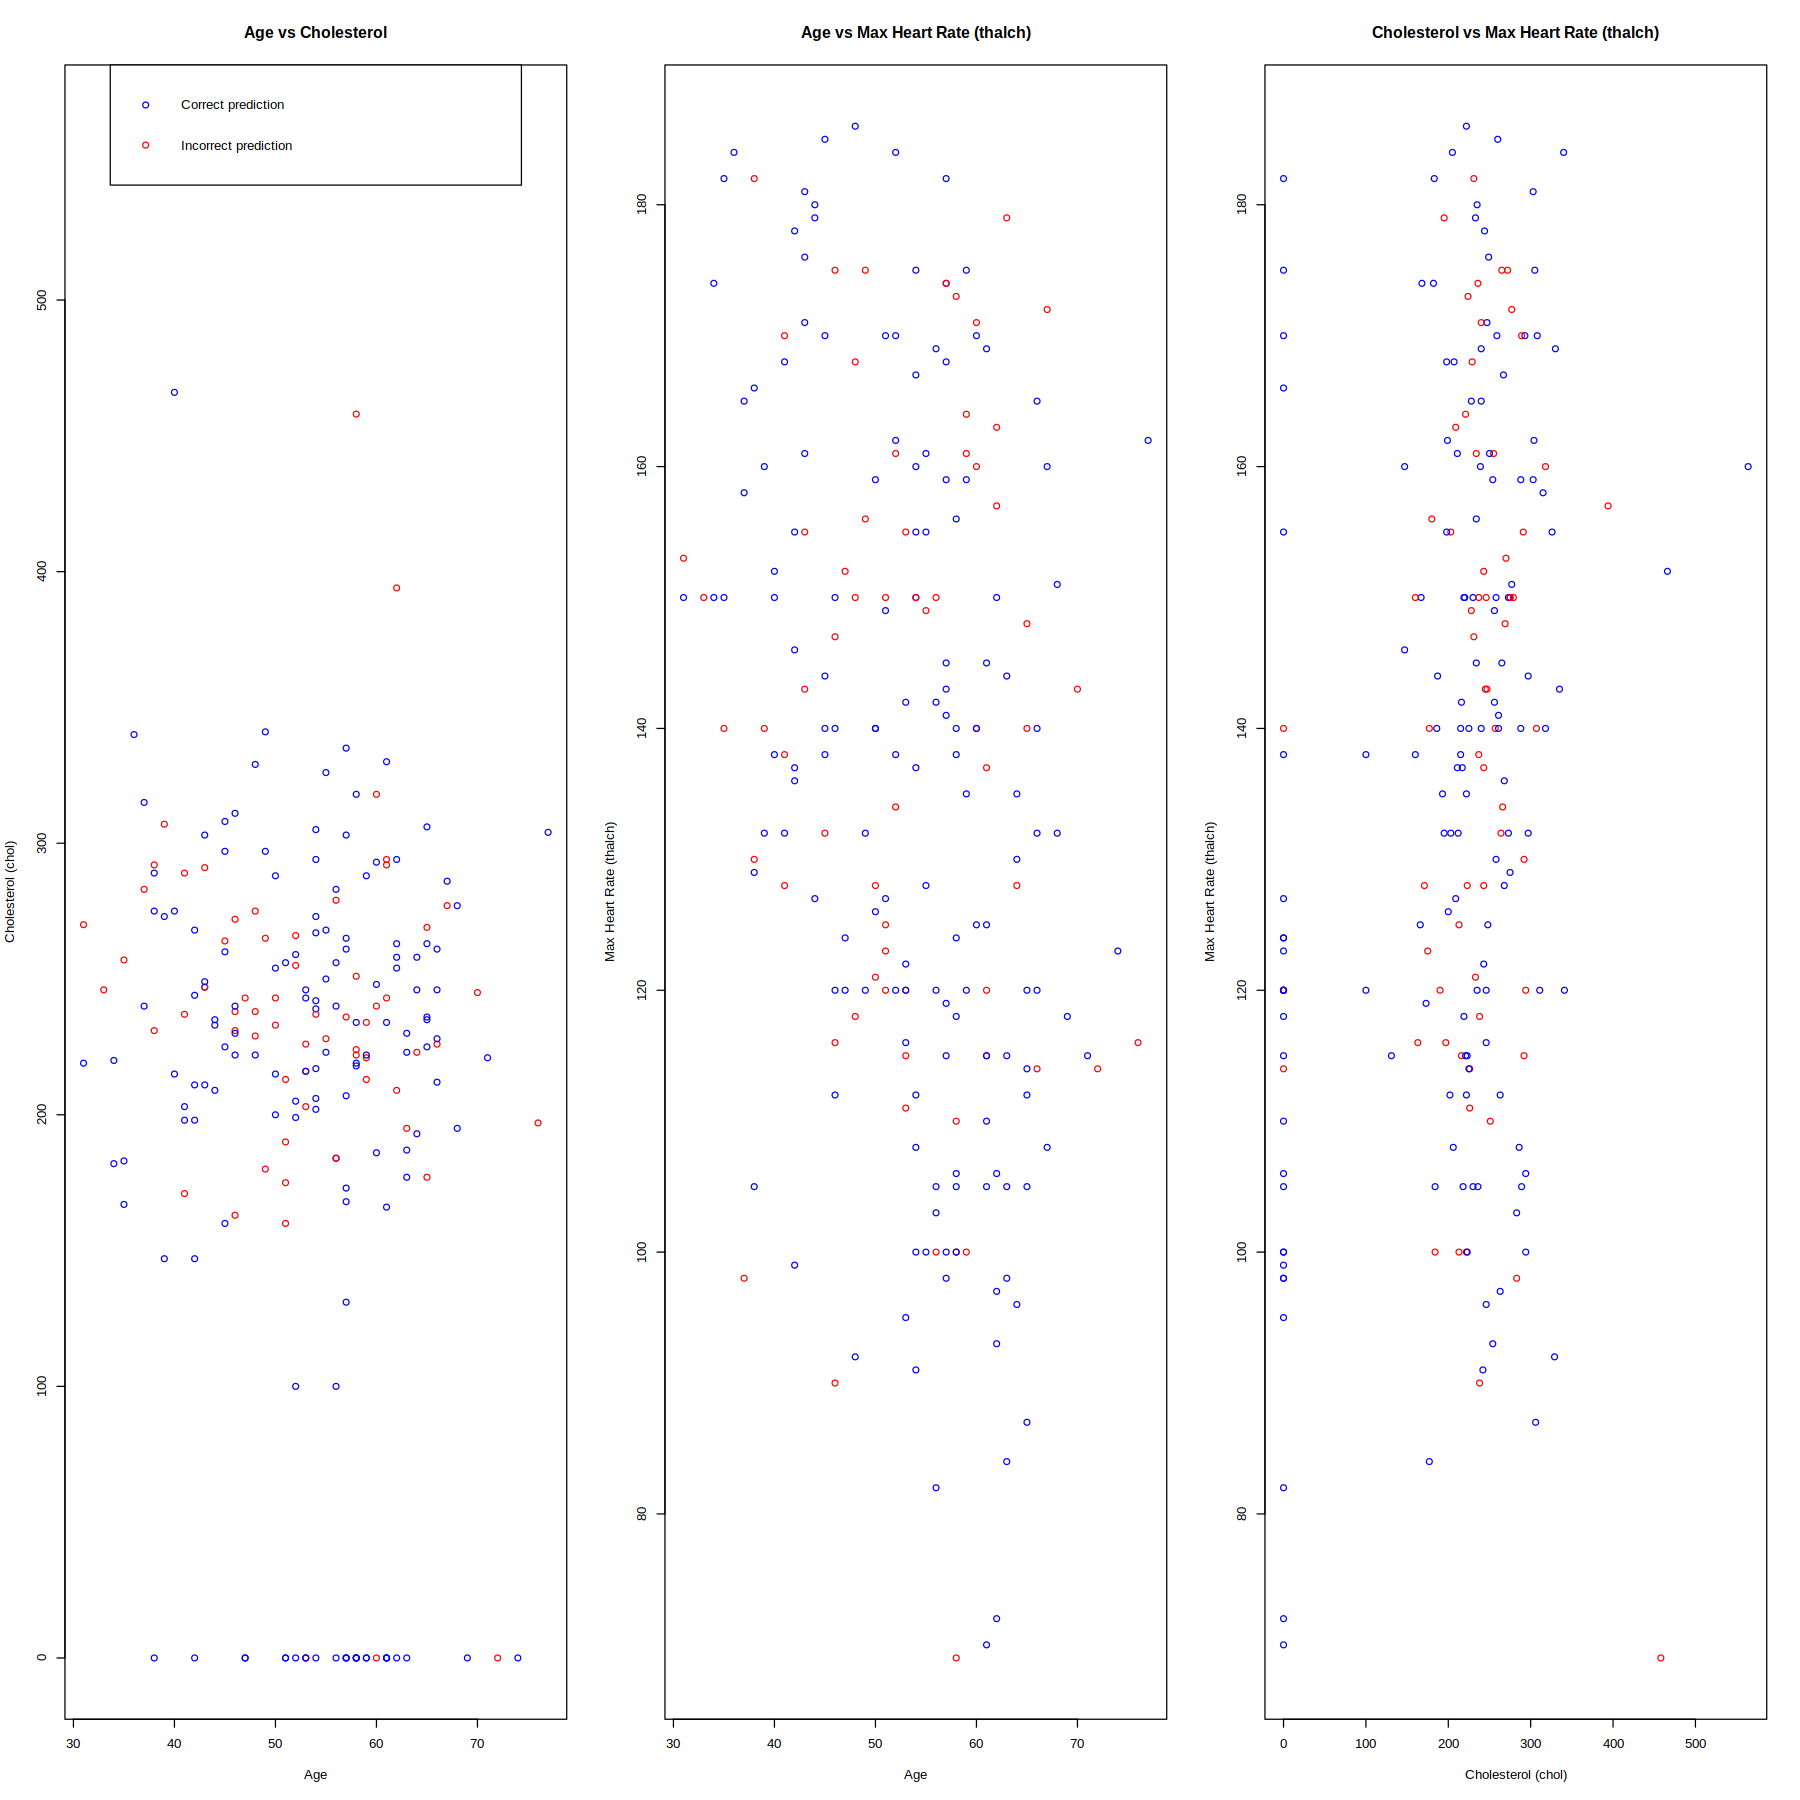

In [65]:
options(repr.plot.width = 15, repr.plot.height = 15)
# Assuming your data frame is named heart_disease_test_predictions
heart_disease_test_predictions$correct <- heart_disease_test_predictions$.pred_class == heart_disease_test_predictions$presence

# Set up the plot layout to have 1 row and 3 columns
par(mfrow = c(1, 3))

# Scatter plot for age vs chol
plot(heart_disease_test_predictions$age, heart_disease_test_predictions$chol, 
     col = ifelse(heart_disease_test_predictions$correct, "blue", "red"), 
     xlab = "Age", ylab = "Cholesterol (chol)",
     main = "Age vs Cholesterol")
legend("top", legend = c("Correct prediction", "Incorrect prediction"), col = c("blue", "red"), pch = 1)

# Scatter plot for age vs thalch
plot(heart_disease_test_predictions$age, heart_disease_test_predictions$thalch, 
     col = ifelse(heart_disease_test_predictions$correct, "blue", "red"), 
     xlab = "Age", ylab = "Max Heart Rate (thalch)",
     main = "Age vs Max Heart Rate (thalch)")

# Scatter plot for chol vs thalch
plot(heart_disease_test_predictions$chol, heart_disease_test_predictions$thalch, 
     col = ifelse(heart_disease_test_predictions$correct, "blue", "red"), 
     xlab = "Cholesterol (chol)", ylab = "Max Heart Rate (thalch)",
     main = "Cholesterol vs Max Heart Rate (thalch)")


`Figure 2.6.1: Plot of accuracy: correct predictions (true positives and true negatives) against all predictions.`

## 3 - Discussion

Our group wanted to find whether K-nearest neighbors classification is an effective method for diagnosing heart disease based on age, resting blood pressure, cholesterol levels, and maximum heart rate as our predictors.<br><br>
#### **3.1 - Choice of Predictors** :

The choice to use these predictors aligns with medical understanding of heart disease risk factors. Age (age) and cholesterol levels (chol) are well-established factors in cardiovascular risk, while maximum heart rate achieved during stress tests (thalch) can indicate cardiovascular performance (Rodgers et al., 2019) and (Jung et al., 2022).

Trestbps (resting blood pressure) also has been found to be linked to increasing heart disease risk but the decision to remove it from our predictors was based on observations from the ggpairs analysis, which indicated a weak influence on heart disease presence (for our dataset). By focusing on more influential predictors (age, cholesterol levels, and maximum heart rate achieved), the model is simplified, potentially reducing noise and improving interpretability.<br><br>



####  **3.2 - Model Performance** : 

In our study, we utilized a k-Nearest Neighbors (KNN) classifier with K = 21 to diagnose heart disease

  -   **Confusion Matrix Overview :** 

We used P (present) as the positive prediction and A (absent) as the negative prediction.

<u>True Positives (TP): 57 </u> - These are cases where our classifier **correctly** predicted heart disease presence (P) when it was actually present (P).
High TP is crucial in medical diagnosis to ensure patients with the condition receive necessary care.

<u>True Negatives (TN): 89</u> - These are cases where our classifier **correctly** predicted no heart disease (A) when it was actually absent (A).
We generally want this to be high as well to avoid unnecessary treatments or anxiety for patients.

<u>False Positives (FP): 27</u> - These are cases where our classifier **incorrectly** predicted heart disease (P) when it was actually absent (A). This is also important to avoid  unnecessary testing, anxiety, and health care costs.


<u>False Negatives (FN): 37</u> - These are cases where our classifier **incorrectly** predicted no heart disease (A) when it was actually present (P).
***'This is particularly critical in a medical setting, as undiagnosed heart disease can have serious, even fatal, consequences.***


 - **Evaluation Metrics**
 
accuracy = number of correct predictions / total number of predictions

precision = number of correct positive predictions / total number of positive predictions

recall = number of correct positive predictions / total number of positive test observations


<u>Accuracy (0.695)</u>:
Accuracy is a measure of the overall correctness of the model. It is the ratio of correctly predicted instances to the total instances. In this case, our model has an accuracy of approximately 70%. This means that the model correctly predicted the labels  P and A around 70% of the time. While this is significantly lower than our target 90%, it's important to consider precision and recall as well.


<u>Precision (0.679)</u>:
Precision is the ratio of correctly predicted positive observations to the total predicted positives. In other words, it measures how many of the predicted positive instances are actually positive. This means that when our model predicts heart disease, there is approximately a 68% chance that the patient actually has the disease. This is extremely lower than the 90% expectation and it suggests that our KNN model might not be effective to predict heart disease.


<u>Recall (0.606)</u>:
Recall, also known as sensitivity or true positive rate, is the ratio of correctly predicted positive observations to all the actual positives. It measures how well the model captures all the positive instances. A recall of approximately 61% indicates that the model correctly identified around 61% of the actual positive instances. It also suggests that **the model misses nearly 40% of actual heart disease cases, which is a significant concern in a clinical context**.<br><br>



#### **3.3 - Result conclusion** :

The **lower accuracy, precision, and recall rates of our model is a significant concern** because in the matters of heart disease, we want to be as precise as possible with any diagnosis in order to ensure necessary and proper treatments. Moreover, we can say that **this K-NN model is not an efficient model to predict heart disease**, as it did not meet the criteria for our original hypothesis in which we anticipated a performance rate of 90% or above for accuracy, precision and recall. The final visualtion plot clearly shows it as we can still identify several incorrect predicitons.<br><br> 




#### **3.4 - The Impacts of the Project Findings and Further Research:**

If KNN proves to be effective, it could contribute to a quicker and more effective diagnosis of heart disease and help professionals make more informed treatment options. This can significantly reduce healthcare expenses- decreasing unnecessary procedures. 
Therefore, We recommend further analysis on the choice and influence of predictors. Investigating other potential predictors might yield better results. Additionally, The choice of k=21 for the KNN algorithm was one configuration among many possibilities. It would be beneficial to conduct a more thorough tuning process, possibly incorporating thorough methods to remove irrelevant variables.<br><br>


#### **3.5 - Future Questions:**
- Are our considered variables the most informative for heart disease diagnosis, or are there other key features that should be considered?
- How does KNN performance compare to other machine learning algorithms or traditional diagnostic methods in diagnosing heart disease?
- Is KNN classification model the best algorithm to approach heart disease diagnosis?




## 4 - References


Bobbio, M., Detrano, R.C., Shandling, A.H., Ellestad, M.H., Clark, J., Brezden, O.S., Abecia, A., & Martínez-Caro, D. (1992). Clinical Assessment of the Probability of Coronary Artery Disease. Medical Decision Making, 12, 197 - 203. https://doi.org/10.1177/0272989X9201200305


Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X. 

Jung, E., Kong, S. Y., Ro, Y. S., Ryu, H. H., & Shin, S. D. (2022). Serum Cholesterol Levels and Risk of Cardiovascular Death: A Systematic Review and a Dose-Response Meta-Analysis of Prospective Cohort Studies. International journal of environmental research and public health, 19(14), 8272. https://doi.org/10.3390/ijerph19148272


Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019). Cardiovascular Risks Associated with Gender and Aging. Journal of cardiovascular development and disease, 6(2), 19. https://doi.org/10.3390/jcdd6020019
